## Problem 2

Student MDPs

In [1]:
import numpy as np
from scipy.optimize import linprog


class StudentMDP:
    def __init__(self, gamma=1):
        self.gamma = gamma
        self.epsilon = 1e-3
        self.state_space = ['s1', 's2', 's3', 's4']
        self.action_space = ['Facebook', 'Quit', 'Study', 'Sleep', 'Pub']
        self.valid_actions = {  's1': ['Facebook', 'Quit'],
                                's2': ['Facebook', 'Study'],
                                's3': ['Sleep', 'Study'],
                                's4': ['Pub', 'Study']}

    def get_new_state(self, state, action):
        # return a list of tuples (probability, next_state, reward)
        if state == 's1':
            if action == 'Facebook':
                return [(1, 's1', -1)]
            if action == 'Quit':
                return [(1, 's2', 0)]
            return None

        if state == 's2':
            if action == 'Facebook':
                return [(1, 's1', -1)]
            if action == 'Study':
                return [(1, 's3', -2)]
            return None

        if state == 's3':
            if action == 'Sleep':
                return [(1, 'done', 0)]
            if action == 'Study':
                return [(1, 's4', -2)]
            return None

        if state == 's4':
            if action == 'Pub':
                return [(0.2, 's2', 1), (0.4, 's3', 1), (0.4, 's4', 1)]
            if action == 'Study':
                return [(1, 'done', 10)]
            return None

        return None


    def get_Q_values(self, v_values):
        # Loop through all states and actions
        for state_idx, state in enumerate(self.state_space):
            for action_idx, action in enumerate(self.action_space):
                # Get the state-action pair details: (probability, next_state, reward)
                transitions = self.get_new_state(state, action)
                if transitions is None:
                    continue
                Q_value = 0
                for prob, next_state, reward in transitions:
                    next_value = 0
                    if next_state != 'done':
                        next_state_idx = self.state_space.index(next_state)
                        next_value = v_values[next_state_idx]
                    Q_value += prob * (reward + self.gamma * next_value)

                # Output the Q-value for the current state-action pair
                print(f"Q({state}, {action}) = {Q_value}")


class Student_Bellman_Expectation(StudentMDP):
    def __init__(self):
        super().__init__()


    def theoretical_method(self):
        A = np.zeros((len(self.state_space), len(self.state_space)))
        b = np.zeros(len(self.state_space))
        A[0, 0], A[0, 1], b[0] = 1, -1, -1
        A[1, 0], A[1, 1], A[1, 2], b[1] = -1, 2, -1, -3
        A[2, 2], A[2, 3], b[2] = 2, -1, -2
        A[3, 1], A[3, 2], A[3, 3], b[3] = -1, -2, 8, 55

        V = np.linalg.solve(A, b)
        print("Theoretical Method:")
        for i, state in enumerate(self.state_space):
            print(f"{state}: {V[i]}")
        return V


    def iterative_policy_evaluation(self):
        V = np.zeros(len(self.state_space))
        iter_num = 0
        while True:
            V_old = V.copy()  # Make a copy of the current value function

            for state_idx, state in enumerate(self.state_space):
                # Reset V[state_idx] to accumulate the value for the current state
                state_value = 0

                # Loop over the valid actions for the current state
                for action in self.valid_actions[state]:
                    transitions = self.get_new_state(state, action)
                    if transitions is None:
                        continue
                    action_value = 0

                    # Calculate the value for the current action under the policy
                    for prob, next_state, reward in transitions:
                        next_value = 0
                        if next_state != 'done':
                            next_state_idx = self.state_space.index(next_state)
                            next_value = V_old[next_state_idx]
                        action_value += prob * (reward + self.gamma * next_value)

                    # Equal Option policy
                    state_value += action_value / len(self.valid_actions[state])

                # Update the value for the current state
                V[state_idx] = state_value

            # Check for convergence (if the value function has changed less than epsilon)
            delta = np.max(np.abs(V - V_old))
            if delta < self.epsilon:
                break
            iter_num += 1

        print(f"Iterative Policy Evaluation finished after {iter_num} iterations:")
        for i, state in enumerate(self.state_space):
            print(f"{state}: {V[i]}")
        return V


class Student_Bellman_Optimal(StudentMDP):
    def __init__(self):
        super().__init__()


    def theoretical_method(self):
        # List to store the coefficients of inequality constraints (A_ub)
        A_ub_rows = []
        b_ub_list = []

        # Loop through each state and action to create the constraints
        for state_idx, state in enumerate(self.state_space):
            for action in self.valid_actions[state]:
                transitions = self.get_new_state(state, action)

                if transitions is None:
                    continue
                # For each state-action pair, create a constraint
                row = np.zeros(len(self.state_space))

                # Loop through the transitions for the current action
                for t, (prob, next_state, reward) in enumerate(transitions):
                    if t == 0:
                        row[state_idx] += -1

                    if next_state == 'done':
                        continue

                    next_state_idx = self.state_space.index(next_state)
                    row[next_state_idx] += self.gamma * prob

                A_ub_rows.append(row)
                b_ub_list.append(-reward)  # -reward from the equation: -V(s) + gamma * V(s') >= -r(s, a)

        # Convert the rows into a numpy array
        A_ub = np.array(A_ub_rows)
        b_ub = np.array(b_ub_list)

        print('Constructed LP constraints:')
        print(f'{A_ub.tolist()} @ V <= {b_ub.tolist()}')
        c = np.ones(len(self.state_space))

        # Solve the linear program to get the optimal state values V_*
        result = linprog(c, A_ub=A_ub, b_ub=b_ub, bounds=(None, None))

        # Check if the problem was solved successfully
        if result.success:
            V = result.x
            for i, state in enumerate(self.state_space):
                print(f"{state}: {V[i]}")
            return V
        else:
            print('Infeasible problem')
            return None


    def policy_evaluation(self, V, policy):
        iteration = 0
        while True:
            V_old = np.copy(V)  # Make a copy of the current value function

            for state_idx, state in enumerate(self.state_space):
                value = 0

                # Loop over the valid actions for the current state
                for action in self.valid_actions[state]:
                    action_idx = self.action_space.index(action)  # Get action index
                    transitions = self.get_new_state(state, action)
                    if transitions is None:
                        continue
                    action_value = 0

                    # Calculate the value for the current action under the policy
                    for prob, next_state, reward in transitions:
                        state_value = 0
                        if next_state != 'done':
                            next_state_idx = self.state_space.index(next_state)
                            state_value = V_old[next_state_idx]
                        action_value += prob * (reward + self.gamma * state_value)

                    # Add the action value to the total value for the state
                    value += policy[state_idx][action_idx] * action_value

                # Update the value for the current state
                V[state_idx] = value

            # Check for convergence (if the value function has changed less than epsilon)
            delta = np.max(np.abs(V - V_old))  # Check the maximum difference
            if delta < self.epsilon:  # If the change is small, stop iterating
                break
            iteration += 1

        print(f"Policy Evaluation finished after {iteration} iterations:")
        return V


    def policy_improvement(self, V, policy):
        stable = True
        for state_idx, state in enumerate(self.state_space):
            max_q = -np.inf
            best_action = None

            # Calculate action values (Q-values) for each action
            for action in self.valid_actions[state]:
                action_idx = self.action_space.index(action)
                transitions = self.get_new_state(state, action)
                if transitions is None:
                    continue
                action_value = 0
                for prob, next_state, reward in transitions:
                    state_value = 0
                    if next_state != 'done':
                        next_state_idx = self.state_space.index(next_state)
                        state_value = V[next_state_idx]
                    action_value += prob * (reward + self.gamma * state_value)

                # Find the best action (maximize Q-value) among all valid actions
                if action_value > max_q:
                    max_q = action_value
                    best_action = action_idx

            # If the best action is different from the current policy, update the policy
            if np.argmax(policy[state_idx]) != best_action:
                stable = False

            # Update the policy: set the best action's probability to 1.0
            policy[state_idx] = np.zeros(len(self.action_space))
            policy[state_idx][best_action] = 1.0

        # print(V, policy)
        return policy, stable


    def policy_iteration_method(self):
        # Initialize the value function and policy
        V = np.zeros(len(self.state_space))
        policy = np.zeros((len(self.state_space), len(self.action_space)))
        for state_idx, state in enumerate(self.state_space):
            actions = self.valid_actions[state]
            for action in actions:
                action_idx = self.action_space.index(action)
                policy[state_idx][action_idx] = 1.0 / len(actions)
        # Policy iteration
        iteration = 0
        while True:
            V = self.policy_evaluation(V, policy)  # Evaluate the policy
            policy, stable = self.policy_improvement(V, policy)  # Improve the policy
            if stable:
                break  # Stop if the policy is stable

            iteration += 1

        print(f"Policy Iteration finished after {iteration} iterations:")
        for i, state in enumerate(self.state_space):
            print(f"State {state}: Value = {V[i]}, Policy = {self.action_space[np.argmax(policy[i])]}")

        return policy, V


    def value_iteration_method(self):
        V = np.zeros(len(self.state_space))  # Initialize state values to 0
        iteration = 0

        while True:
            V_old = np.copy(V)  # Make a copy of the current value function

            for state_idx, state in enumerate(self.state_space):
                max_q_value = -np.inf  # Initialize the max Q-value for the state

                # Loop over the valid actions for the current state
                for action in self.valid_actions[state]:
                    action_idx = self.action_space.index(action)  # Get action index
                    transitions = self.get_new_state(state, action)
                    if transitions is None:
                        continue
                    action_value = 0

                    # Calculate the value for the current action under the policy
                    for prob, next_state, reward in transitions:
                        state_value = 0
                        if next_state != 'done':
                            next_state_idx = self.state_space.index(next_state)
                            state_value = V_old[next_state_idx]
                        action_value += prob * (reward + self.gamma * state_value)

                    # Find the maximum Q-value for the current state
                    max_q_value = max(max_q_value, action_value)

                # Update the value for the current state with the max Q-value
                V[state_idx] = max_q_value

            # Check for convergence (if the value function has changed less than epsilon)
            delta = np.max(np.abs(V - V_old))  # Check the maximum difference
            if delta < self.epsilon:  # If the change is small, stop iterating
                break

            iteration += 1

        # After the value function converges, derive the optimal policy
        policy = np.zeros((len(self.state_space), len(self.action_space)))

        for state_idx, state in enumerate(self.state_space):
            action_values = np.zeros(len(self.action_space))

            # Calculate action values (Q-values) for each action
            for action_idx, action in enumerate(self.action_space):
                transitions = self.get_new_state(state, action)
                if transitions is None:
                    continue
                action_value = 0
                for prob, next_state, reward in transitions:
                    state_value = 0
                    if next_state != 'done':
                        next_state_idx = self.state_space.index(next_state)
                        state_value = V[next_state_idx]
                    action_value += prob * (reward + self.gamma * state_value)

                action_values[action_idx] = action_value

            # Find the best action for the current state
            best_action_idx = np.argmax(action_values)
            policy[state_idx] = np.zeros(len(self.action_space))
            policy[state_idx][best_action_idx] = 1.0  # Set the best action to 1

        print(f"Value Iteration finished after {iteration} iterations:")
        for i, state in enumerate(self.state_space):
            print(f"State {state}: Value = {V[i]}, Policy = {self.action_space[np.argmax(policy[i])]}")

        return policy, V

(a) Given the equal option policy, reproduce the state values \& state-action values for student MDP with both theoretical method and iterative policy evaluation method. Then discuss the pros and cons of each method.

In [2]:
# Theoretical Method
student_bellman_exception = Student_Bellman_Expectation()
V = student_bellman_exception.theoretical_method()
student_bellman_exception.get_Q_values(V)

Theoretical Method:
s1: -2.3076923076923066
s2: -1.3076923076923066
s3: 2.6923076923076934
s4: 7.384615384615385
Q(s1, Facebook) = -3.3076923076923066
Q(s1, Quit) = -1.3076923076923066
Q(s2, Facebook) = -3.3076923076923066
Q(s2, Study) = 0.6923076923076934
Q(s3, Study) = 5.384615384615385
Q(s3, Sleep) = 0
Q(s4, Study) = 10
Q(s4, Pub) = 4.76923076923077


In [3]:
# Iterative Policy Evaluation
student_bellman_exception = Student_Bellman_Expectation()
V = student_bellman_exception.iterative_policy_evaluation()
student_bellman_exception.get_Q_values(V)

Iterative Policy Evaluation finished after 26 iterations:
s1: -2.3116692858874535
s2: -1.3102871136591983
s3: 2.6919968668115835
s4: 7.384101760095685
Q(s1, Facebook) = -3.3116692858874535
Q(s1, Quit) = -1.3102871136591983
Q(s2, Facebook) = -3.3116692858874535
Q(s2, Study) = 0.6919968668115835
Q(s3, Study) = 5.384101760095685
Q(s3, Sleep) = 0
Q(s4, Study) = 10
Q(s4, Pub) = 4.768382028031068


(b) Reproduce the optimal state values, optimal state-action values, and optimal policy for student MDP with theoretical method, policy iteration method and value iteration method. Then discuss the pros and cons of each method.

In [4]:
# Theoretical Method
student_bellman_optimal = Student_Bellman_Optimal()
V = student_bellman_optimal.theoretical_method()
student_bellman_optimal.get_Q_values(V)

Constructed LP constraints:
[[0.0, 0.0, 0.0, 0.0], [-1.0, 1.0, 0.0, 0.0], [1.0, -1.0, 0.0, 0.0], [0.0, -1.0, 1.0, 0.0], [0.0, 0.0, -1.0, 0.0], [0.0, 0.0, -1.0, 1.0], [0.0, 0.2, 0.4, -0.6], [0.0, 0.0, 0.0, -1.0]] @ V <= [1, 0, 1, 2, 0, 2, -1, -10]
s1: 6.0
s2: 6.0
s3: 8.0
s4: 10.0
Q(s1, Facebook) = 5.0
Q(s1, Quit) = 6.0
Q(s2, Facebook) = 5.0
Q(s2, Study) = 6.0
Q(s3, Study) = 8.0
Q(s3, Sleep) = 0
Q(s4, Study) = 10
Q(s4, Pub) = 9.4


In [5]:
# Policy Iteration Method
student_bellman_optimal = Student_Bellman_Optimal()
_, V = student_bellman_optimal.policy_iteration_method()
student_bellman_optimal.get_Q_values(V)

Policy Evaluation finished after 26 iterations:
Policy Evaluation finished after 4 iterations:
Policy Iteration finished after 1 iterations:
State s1: Value = 6.0, Policy = Quit
State s2: Value = 6.0, Policy = Study
State s3: Value = 8.0, Policy = Study
State s4: Value = 10.0, Policy = Study
Q(s1, Facebook) = 5.0
Q(s1, Quit) = 6.0
Q(s2, Facebook) = 5.0
Q(s2, Study) = 6.0
Q(s3, Study) = 8.0
Q(s3, Sleep) = 0
Q(s4, Study) = 10
Q(s4, Pub) = 9.4


In [6]:
# Value Iteration Method
student_bellman_optimal = Student_Bellman_Optimal()
_, V = student_bellman_optimal.value_iteration_method()
student_bellman_optimal.get_Q_values(V)

Value Iteration finished after 4 iterations:
State s1: Value = 6.0, Policy = Quit
State s2: Value = 6.0, Policy = Study
State s3: Value = 8.0, Policy = Study
State s4: Value = 10.0, Policy = Study
Q(s1, Facebook) = 5.0
Q(s1, Quit) = 6.0
Q(s2, Facebook) = 5.0
Q(s2, Study) = 6.0
Q(s3, Study) = 8.0
Q(s3, Sleep) = 0
Q(s4, Study) = 10
Q(s4, Pub) = 9.4


## Problem 3
5x5 Grid World(Example 3.5 Gridworld in the book “Reinforcement Learning: An Introduction” , the second edition)

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import linprog


class GridWorld:
    def __init__(self, width=5, height=5, gamma=0.9, epsilon=1e-3):
        self.A_pos = (0, 1)
        self.A_new_pos = (4, 1)
        self.B_pos = (0, 3)
        self.B_new_pos = (2, 3)
        self.A_reward = 10
        self.B_reward = 5
        self.out_grid_reward = -1
        self.normal_reward = 0
        self.width = width
        self.height = height
        self.gamma = gamma
        self.epsilon = epsilon

        # north, south, east, west
        # (-1, 0), (1, 0), (0, 1), (0, -1)
        self.action_space = [(-1, 0), (1, 0), (0, 1), (0, -1)]
        self.state_space = [(i, j) for i in range(height) for j in range(width)]


    def get_new_state(self, state, action):
        # special cases
        if state == self.A_pos:
            return self.A_new_pos, self.A_reward
        if state == self.B_pos:
            return self.B_new_pos, self.B_reward

        new_state = (state[0] + action[0], state[1] + action[1])
        # move out of the grid
        if new_state[0] < 0 or new_state[0] >= self.height or new_state[1] < 0 or new_state[1] >= self.width:
            return state, self.out_grid_reward

        # normal cases
        return new_state, self.normal_reward


    def draw_value_grid(self, values, title='State Value Function', fmt='{:.1f}'):
        R, C = values.shape

        _, ax = plt.subplots(figsize=(C * 1.1, R * 1.1))
        ax.set_xlim(0, C);  ax.set_ylim(0, R);  ax.axis('off')

        # grid
        for x in range(C+1):
            ax.plot([x, x], [0, R], color='black', lw=1.5)
        for y in range(R+1):
            ax.plot([0, C], [y, y], color='black', lw=1.5)

        # value in grid
        for r in range(R):
            for c in range(C):
                ax.text(c + 0.5, R - r - 0.5, fmt.format(values[r, c]), ha='center', va='center', fontsize=12)

        ax.set_title(title, fontsize=16, pad=12)
        plt.tight_layout()
        plt.show()


    def get_Q_values(self, V):
        V = V.flatten()
        Q = np.zeros((self.height * self.width, len(self.action_space)))
        for state_idx, state in enumerate(self.state_space):
            for action_idx, action in enumerate(self.action_space):
                new_state, reward = self.get_new_state(state, action)
                new_state_idx = self.state_space.index(new_state)
                Q[state_idx, action_idx] = reward + self.gamma * V[new_state_idx]
        return Q


    def draw_policy(self, Q, title):
        R, C, A = Q.shape

        _, ax = plt.subplots(figsize=(C * 1.1, R * 1.1))
        ax.set_xlim(0, C);  ax.set_ylim(0, R);  ax.axis('off')

        for x in range(C+1):
            ax.plot([x, x], [0, R], color='black', lw=1.5)
        for y in range(R+1):
            ax.plot([0, C], [y, y], color='black', lw=1.5)

        for r in range(R):
            for c in range(C):
                max_q = Q[r, c, :].max()
                dirs = []
                for a in range(A):
                    if Q[r, c, a] >= max_q - self.epsilon:
                        dirs.append(a)
                cx, cy = c + 0.5, R - r - 0.5
                for d in dirs:
                    dx, dy = self.action_space[d]
                    # different coordinate system
                    ax.arrow(cx , cy, dy * 0.4, -dx * 0.4, head_width=0.12, head_length=0.12, length_includes_head=True, fc='black', ec='black', lw=1.25)

        ax.set_title(title, fontsize=16, pad=12)
        plt.tight_layout()
        plt.show()


    def show_Q_values(self, Q, method):
        actions = ['north', 'south', 'east', 'west']
        for action_idx, action in enumerate(actions):
            self.draw_value_grid(Q[:, action_idx].reshape((self.height, self.width)), title=f'{method} optimal\nstate-action values for action {action}')


class Bellman_Expectation(GridWorld):
    def __init__(self, width=5, height=5, gamma=0.9, epsilon=1e-3, pi='uniform'):
        super().__init__(width, height, gamma, epsilon)
        if pi == 'uniform':
            pi = np.ones(len(self.action_space)) / len(self.action_space)
        self.pi = pi

        self.R = np.zeros((self.height, self.width))
        for action_idx, action in enumerate(self.action_space):
            for i in range(self.height):
                for j in range(self.width):
                    self.R[i, j] += pi[action_idx] * self.get_new_state((i, j), action)[1]
        print('Expected Reward for all states =\n', self.R.flatten())

        self.P = np.zeros((self.height * self.width, self.height * self.width))
        for state_idx, state in enumerate(self.state_space):
            for action_idx, action in enumerate(self.action_space):
                new_state, _ = self.get_new_state(state, action)
                new_state_idx = self.state_space.index(new_state)
                self.P[state_idx, new_state_idx] += pi[action_idx]
        print('Transition probability matrix =\n', self.P)


    def theoretical_method(self):
        V = np.linalg.inv(np.eye(len(self.state_space)) - self.gamma * self.P) @ self.R.flatten()
        V = V.reshape((self.height, self.width))
        print('Theoretical state values =\n', V)
        self.draw_value_grid(V, title='Theoretical method state values')


    def iterative_policy_evaluation_method(self):
        iter_num = 0
        V = np.zeros((self.height, self.width)).flatten()
        R_flatten = self.R.flatten()
        while True:
            V_old = V.copy()
            V = R_flatten + self.gamma * self.P @ V_old
            delta = np.max(np.abs(V - V_old))
            if delta < self.epsilon:
                break
            iter_num += 1

        V = V.reshape((self.height, self.width))
        print(f'After {iter_num} iterations\nIterative policy evaluation method state values =\n', V)
        self.draw_value_grid(V, title='Iterative policy evaluation method state values')


class Bellman_Optimal(GridWorld):
    def __init__(self, width=5, height=5, gamma=0.9, epsilon=1e-3):
        super().__init__(width, height, gamma, epsilon)


    def theoritical_method(self):
        # constrians: A_ub * V <= b_ub
        A_ub_rows = []
        b_ub_list = []

        for state_idx, state in enumerate(self.state_space):
            for action in self.action_space:
                new_state, reward = self.get_new_state(state, action)
                new_state_idx = self.state_space.index(new_state)

                # constrians：   V[s] >= reward + gamma * V[new_state]
                # standard form: -V[s] + gamma * V[new_state] <= -reward
                row = np.zeros(len(self.state_space))
                row[state_idx] += -1
                row[new_state_idx] += self.gamma
                A_ub_rows.append(row)
                b_ub_list.append(-reward)

        A_ub = np.array(A_ub_rows)
        b_ub = np.array(b_ub_list)
        c = np.ones(len(self.state_space))
        # c = np.zeros(len(self.state_space))

        result = linprog(c, A_ub=A_ub, b_ub=b_ub, bounds=(None, None))
        if result.success:
            V = result.x.reshape((self.height, self.width))
            print('Theoritical method state values =\n', V)
            self.draw_value_grid(V, title='Theoritical method optimal state values')
            return V
        else:
            print('Infeasible problem')


    def policy_evaluation(self, V, policy):
        while True:
            old_V = np.copy(V)
            for state_idx, state in enumerate(self.state_space):
                # We compute the value for each state based on its policy
                value = 0
                for action_idx, action in enumerate(self.action_space):
                    new_state, reward = self.get_new_state(state, action)
                    new_state_idx = self.state_space.index(new_state)
                    value += policy[state_idx][action_idx] * (reward + self.gamma * V[new_state_idx])

                V[state_idx] = value  # Update value for the state

            delta = np.max(np.abs(V - old_V))  # Check for convergence
            if delta < self.epsilon:
                break
        return V


    def policy_improvement(self, V, policy):
        stable = True
        for state_idx, state in enumerate(self.state_space):
            action_values = np.zeros(len(self.action_space))

            # Calculate action values (Q-values)
            for action_idx, action in enumerate(self.action_space):
                new_state, reward = self.get_new_state(state, action)
                new_state_idx = self.state_space.index(new_state)
                action_values[action_idx] = reward + self.gamma * V[new_state_idx]

            # Find the best action
            best_action = np.argmax(action_values)

            # If the best action is different from the current policy, update the policy
            if np.argmax(policy[state_idx]) != best_action:
                stable = False

            policy[state_idx] = np.zeros(len(self.action_space))
            policy[state_idx][best_action] = 1.0  # Assign 1.0 probability to the best action

        return policy, stable


    def policy_iteration(self):
        V = np.zeros(self.height * self.width)
        policy = np.ones((self.height * self.width, len(self.action_space))) / len(self.action_space)

        # policy iteration
        while True:
            V = self.policy_evaluation(V, policy)
            policy, stable = self.policy_improvement(V, policy)
            if stable:
                break

        V = V.reshape((self.height, self.width))
        print('Policy iteration method state values =\n', V)
        self.draw_value_grid(V, title='Policy iteration method optimal state values')
        return V


    def value_iteration(self):
        V = np.zeros((self.height, self.width))
        Q = np.zeros((self.height, self.width, 4))
        while True:
            V_old = np.copy(V)
            for i in range(self.height):
                for j in range(self.width):
                    for k, act in enumerate(self.action_space):
                        newState, reward = self.get_new_state((i, j), act)
                        Q[i, j, k] = reward + self.gamma * V_old[newState]
                    V[i, j] = np.max(Q[i, j, :])
            if np.sum(np.abs(V - V_old)) < self.epsilon:
                break

        V = V.reshape((self.height, self.width))
        print('Value iteration method state values =\n', V)
        self.draw_value_grid(V, title='Value iteration method optimal state values')
        return V, Q

(a) Find the state values under the uniform random policy with both theoretical method and iterative policy
evaluation method.

Environment set up:

In [8]:
bellman_exception = Bellman_Expectation(pi='uniform')

Expected Reward for all states =
 [-0.5  10.   -0.25  5.   -0.5  -0.25  0.    0.    0.   -0.25 -0.25  0.
  0.    0.   -0.25 -0.25  0.    0.    0.   -0.25 -0.5  -0.25 -0.25 -0.25
 -0.5 ]
Transition probability matrix =
 [[0.5  0.25 0.   0.   0.   0.25 0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   1.   0.   0.   0.  ]
 [0.   0.25 0.25 0.25 0.   0.   0.   0.25 0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   1.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.25 0.5  0.   0.   0.   0.   0.25 0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.25 0.   0.   0.   0.   0.25 0.25 0.   0.   0.   0.25 0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.25 0

Theoretical state values =
 [[ 3.30899634  8.78929186  4.42761918  5.32236759  1.49217876]
 [ 1.52158807  2.99231786  2.25013995  1.9075717   0.54740271]
 [ 0.05082249  0.73817059  0.67311326  0.35818621 -0.40314114]
 [-0.9735923  -0.43549543 -0.35488227 -0.58560509 -1.18307508]
 [-1.85770055 -1.34523126 -1.22926726 -1.42291815 -1.97517905]]


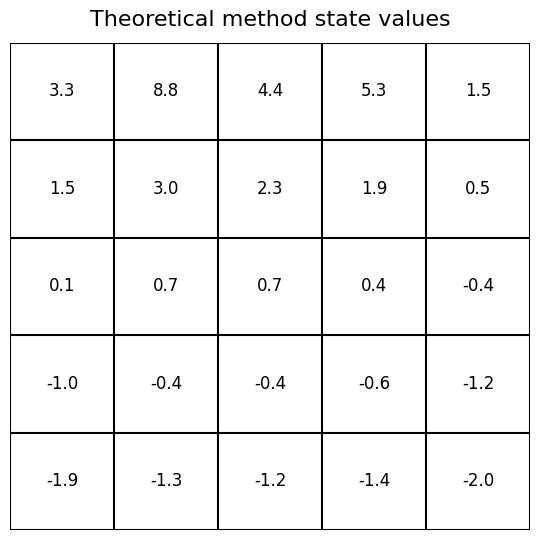

In [9]:
# theoretical method
bellman_exception.theoretical_method()

After 26 iterations
Iterative policy evaluation method state values =
 [[ 3.31622717  8.79643949  4.43397809  5.32815125  1.49730034]
 [ 1.52865327  2.99913874  2.25638959  1.91323889  0.55261953]
 [ 0.05783708  0.74496493  0.67945017  0.36407848 -0.39757709]
 [-0.96647259 -0.42857279 -0.34826151 -0.57934475 -1.17702656]
 [-1.85047365 -1.33814749 -1.22244561 -1.41635457 -1.96879281]]


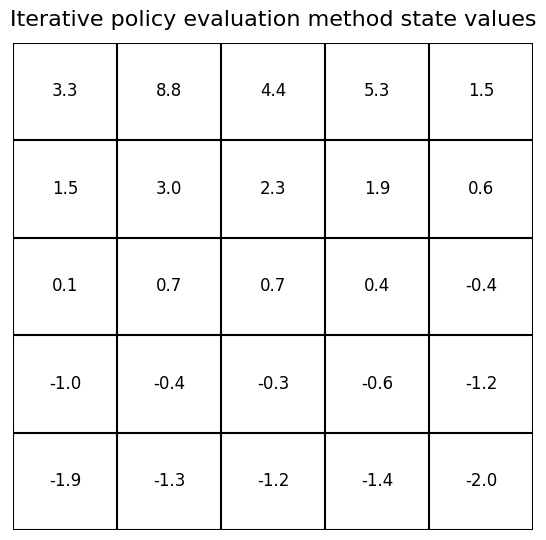

In [10]:
# iterative policy evaluation method
bellman_exception.iterative_policy_evaluation_method()

(b) Reproduce the optimal state values, optimal state-action values, and optimal policy with theoretical
method, policy iteration method and value iteration method.

Environment set up:

In [11]:
bellman_optimal = Bellman_Optimal()

Theoritical method state values =
 [[21.97748529 24.4194281  21.97748529 19.4194281  17.47748529]
 [19.77973676 21.97748529 19.77973676 17.80176308 16.02158677]
 [17.80176308 19.77973676 17.80176308 16.02158677 14.4194281 ]
 [16.02158677 17.80176308 16.02158677 14.4194281  12.97748529]
 [14.4194281  16.02158677 14.4194281  12.97748529 11.67973676]]


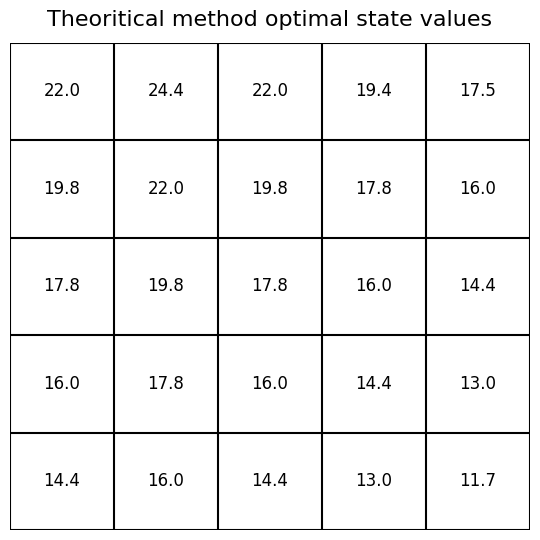

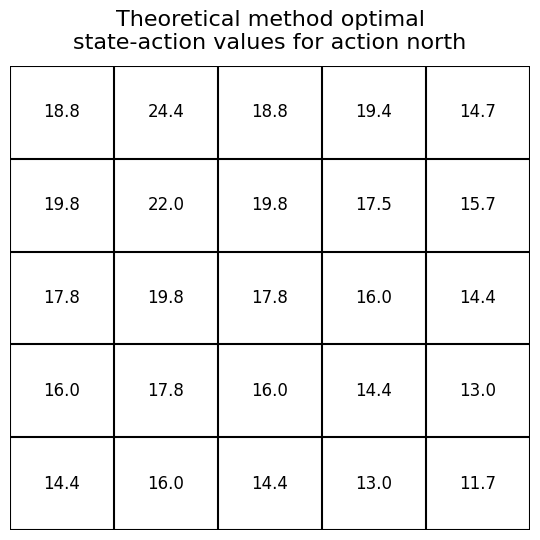

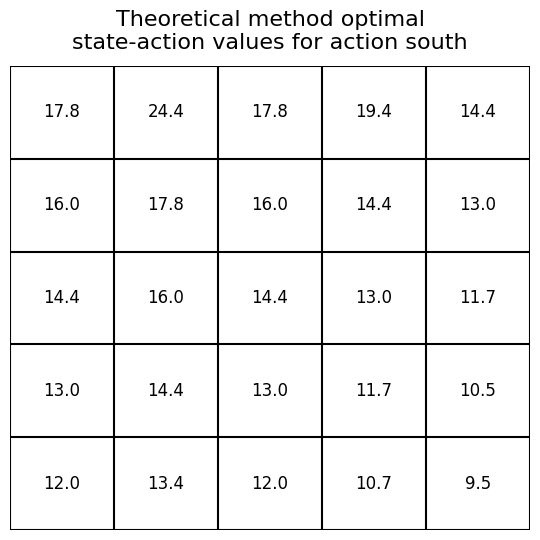

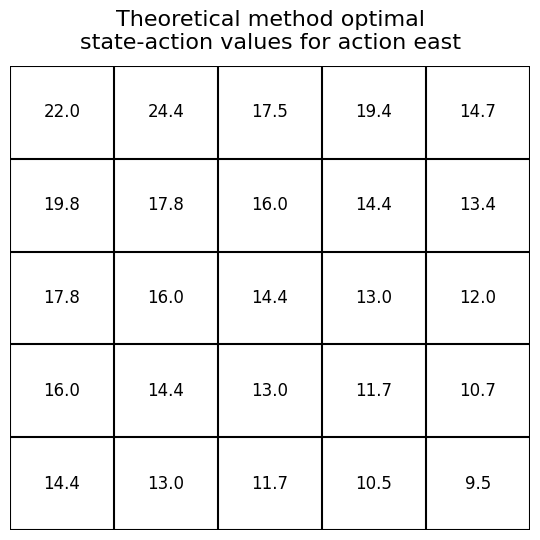

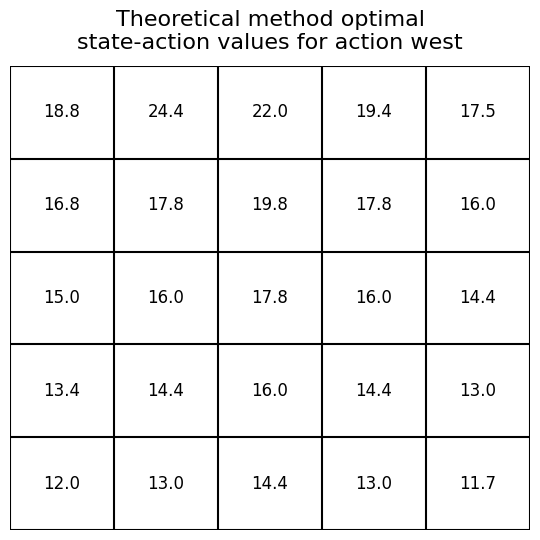

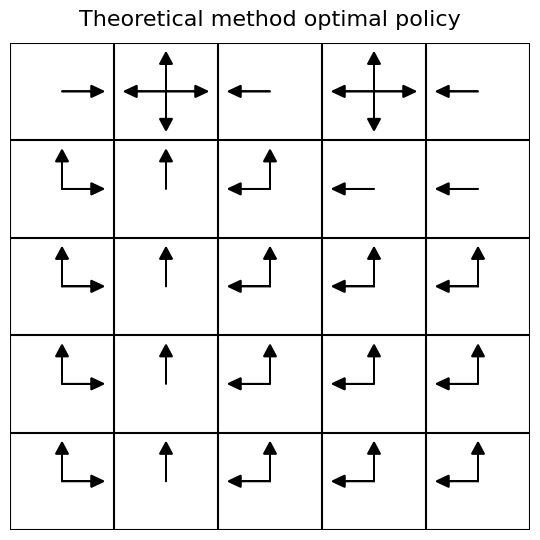

In [12]:
# theoretical method
V = bellman_optimal.theoritical_method()
Q = bellman_optimal.get_Q_values(V)
bellman_optimal.show_Q_values(Q, 'Theoretical method')
bellman_optimal.draw_policy(Q.reshape(5, 5, 4), title='Theoretical method optimal policy')

Policy iteration method state values =
 [[21.97748462 24.41942766 21.97748489 19.41942766 17.47748489]
 [19.77973615 21.97748489 19.7797364  17.80176276 16.02158649]
 [17.80176254 19.7797364  17.80176276 16.02158649 14.41942784]
 [16.02158629 17.80176276 16.02158649 14.41942784 12.97748505]
 [14.41942766 16.02158649 14.41942784 12.97748505 11.67973655]]


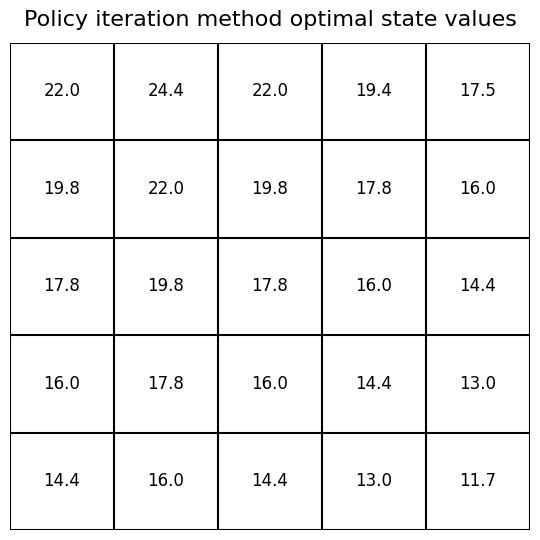

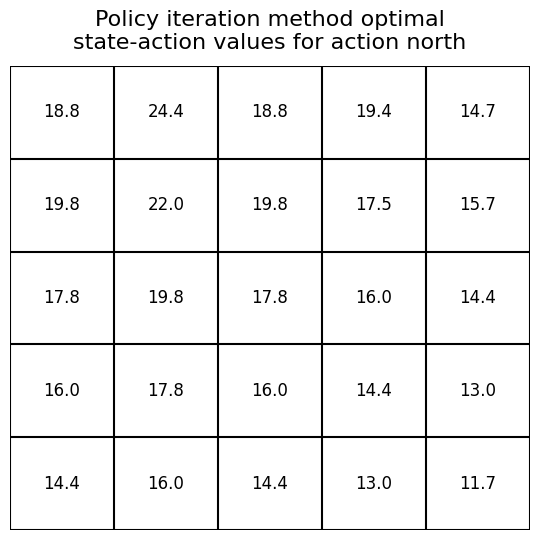

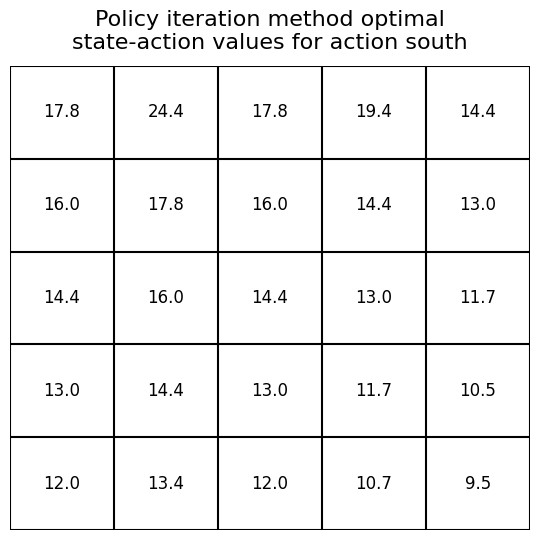

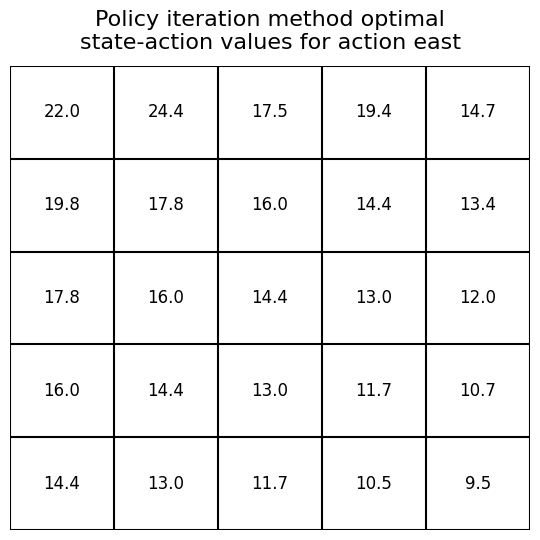

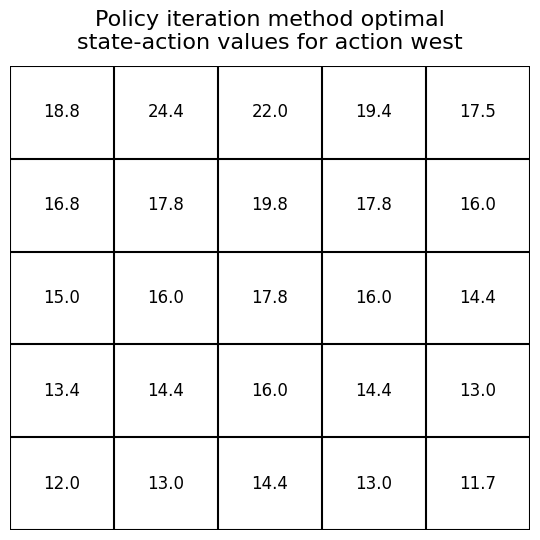

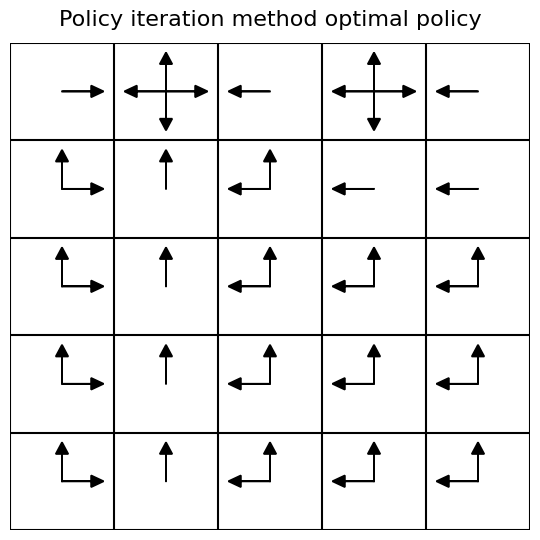

In [13]:
# policy iteration method
V = bellman_optimal.policy_iteration()
Q = bellman_optimal.get_Q_values(V)
bellman_optimal.show_Q_values(Q, 'Policy iteration method')
bellman_optimal.draw_policy(Q.reshape(5, 5, 4), title='Policy iteration method optimal policy')

Value iteration method state values =
 [[21.97714059 24.4190451  21.97714059 19.4190451  17.47714059]
 [19.77942653 21.97714059 19.77942653 17.80129024 16.02116122]
 [17.80129024 19.77942653 17.80129024 16.02116122 14.4190451 ]
 [16.02116122 17.80129024 16.02116122 14.4190451  12.97714059]
 [14.4190451  16.02116122 14.4190451  12.97714059 11.67942653]]


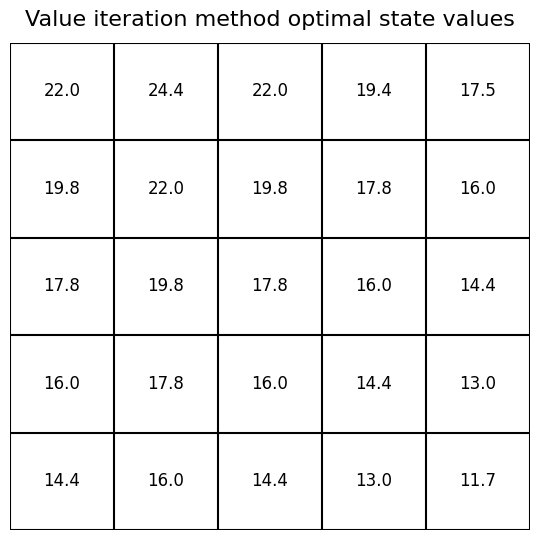

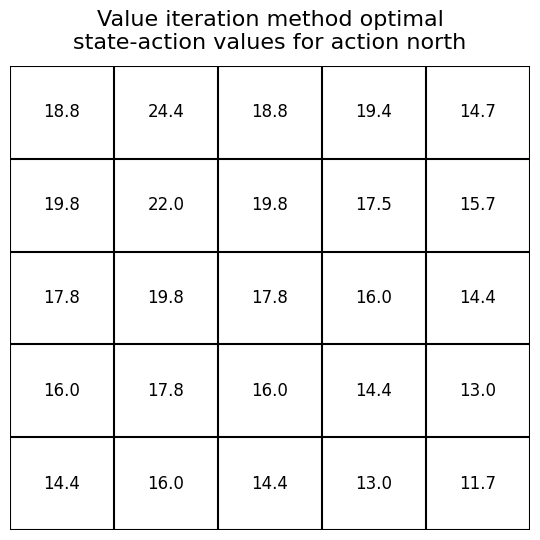

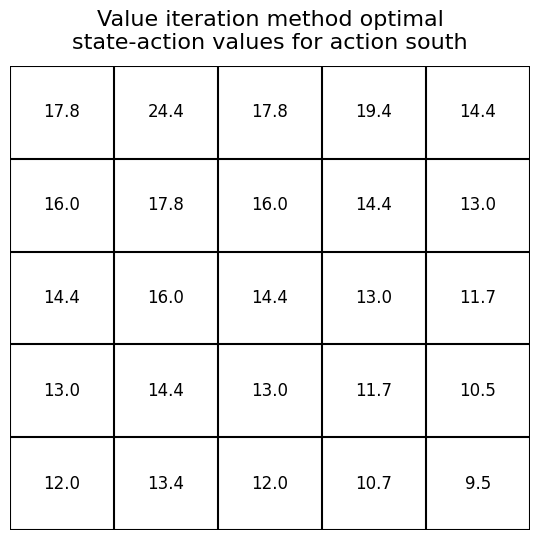

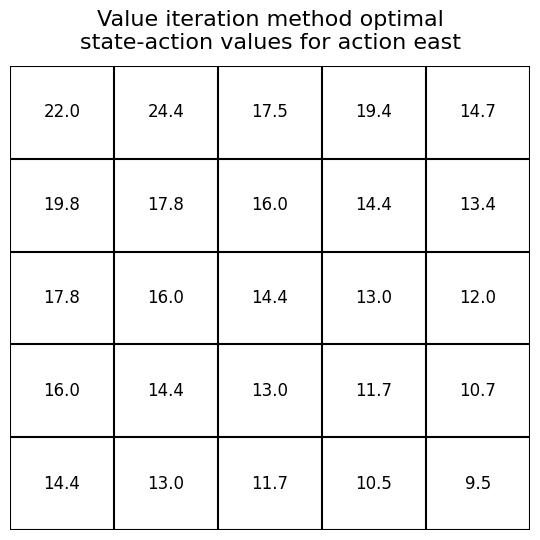

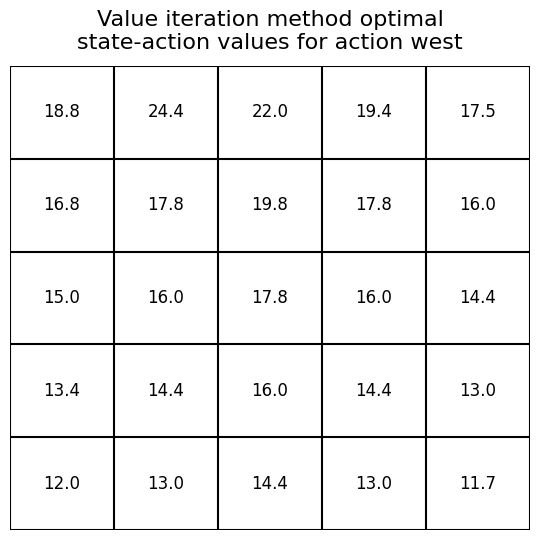

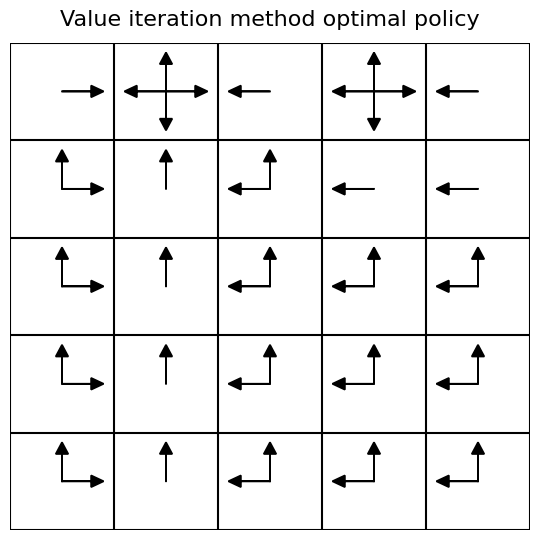

In [14]:
# value iteration method
V, Q = bellman_optimal.value_iteration()
bellman_optimal.show_Q_values(Q.reshape(25, 4), 'Value iteration method')
bellman_optimal.draw_policy(Q, title='Value iteration method optimal policy')

## Problem 8

Bayesian Bandit Process.

(a) One intuitive policy suggests that at each stage we should pull the arm for which the current expected value of θi is the largest. This policy behaves very good in most cases. However, it is unfortunately not optimal. Please provide an example to show why such policy is not optimal.

In [ ]:
alpha = [0, 1, 1]
beta = [0, 1, 1]

theta_oracled_twoarm = [0, 0.7, 0.5]

def intuitive(gamma, N):
    gamma_pow = 1
    reward = 0
    for t in (range(1, N + 1)):
        mean1 = alpha[1] / (alpha[1] + beta[1])
        mean2 = alpha[2] / (alpha[2] + beta[2])
        if mean1 > mean2:
            arm = 1
        elif mean1 < mean2:
            arm = 2
        else:
            arm = np.random.choice([1, 2])

        r_i = np.random.binomial(1, theta_oracled_twoarm[arm]) # r_i ~ Bern(theta_oracled[arm])
        if r_i == 1:
            alpha[arm] += 1
            reward += gamma_pow
        else:
            beta[arm] += 1
        gamma_pow *= gamma

    return reward


alpha = [0, 1, 1]
beta =  [0, 1, 1]

def close_prob_sim(p1, p2, gamma, N=1000):
    # the res[0] is the number of the cases that our algorithm gets greater reward.
    res = [0, 0]
    est_p1 = p1 / (1 - gamma) # est_p1(arm1) is the better reward
    est_p2 = p2 / (1 - gamma) # est_p2(arm2) is the worse reward
    for i in range(N):
        reward = intuitive(gamma, N)

        # close to better reward
        if (abs(reward - est_p1) < abs(reward - est_p2)):
            res[0] += 1

        # close to worse reward
        if (abs(reward - est_p1) > abs(reward - est_p2)):
            res[1] += 1
    return res

est_res = close_prob_sim(0.8, 0.7, 0.9, 1000)
print("The number of cases that the final case converge to ideal case: ", est_res[0])
print("The number of cases that the final case converge to non-ideal case: ", est_res[1])

The number of cases that the final case converge to ideal case:  308
The number of cases that the final case converge to non-ideal case:  692


(d) Find the optimal policy. (Hint: Gittins index policy)

In [22]:
dict = {}

# the first return value ois the calculated R, and the second parameter is which arm to pull
def R(a1, b1, a2, b2, gamma, count):
    if ((a1, a2, b1, b2) in dict): # if the value is already in the dictionary
        return dict[(a1, a2, b1, b2)]

    # bound condition
    # suppose that exploration 1000 times is enough for exploitation
    if count > 50:
        mean1 = a1 / (a1 + b1)
        mean2 = a2 / (a2 + b2)
        if mean1 > mean2:
            return mean1
        else:
            return mean2

    # transfer fuction
    R1 = a1 / (a1 + b1) * (1 + gamma * R(a1 + 1, b1, a2, b2, gamma, count + 1)) + b1 / (a1 + b1) * (gamma * R(a1, b1 + 1, a2, b2, gamma, count + 1))
    R2 = a2 / (a2 + b2) * (1 + gamma * R(a1, b1, a2 + 1, b2, gamma, count + 1)) + b2 / (a2 + b2) * (gamma * R(a1, b1, a2, b2 + 1, gamma, count + 1))

    if R1 > R2:
        reward = R1
    else:
        reward = R2

    dict[(a1, a2, b1, b2)] = reward # store the value in the dictionary
    return reward